# 🧠 Sistema de Clasificación de Imágenes con TensorFlow - MilkyrAI

**Versión:** 2.1.0  
**Autor:** Clevervi  
**Fecha:** 2025-01-05  

---

## Descripción
Este notebook implementa un sistema robusto de clasificación de imágenes utilizando modelos preentrenados de TensorFlow. Incluye manejo avanzado de errores, logging, visualizaciones mejoradas y análisis detallado de predicciones.

### Características principales:
- ✅ Carga segura de modelos con manejo de errores
- ✅ Sistema de logging profesional
- ✅ Visualizaciones mejoradas con matplotlib
- ✅ Soporte para múltiples formatos de imagen
- ✅ Benchmarking de rendimiento
- ✅ Exportación de resultados
- ✅ Configuración modular
- ✅ **NUEVO**: Análisis detallado de predicciones

## 1. 📦 Instalación y Configuración

In [10]:
# -*- coding: utf-8 -*-
"""Instalación de dependencias con versiones específicas para reproducibilidad"""

!pip install --quiet --upgrade pip

# Dependencias principales
!pip install --quiet \
    tensorflow==2.13.0 \
    pillow==10.0.0 \
    numpy==1.24.3 \
    matplotlib==3.7.1 \
    seaborn==0.12.2 \
    pandas==2.0.3 \
    scikit-learn==1.3.0 \
    opencv-python-headless==4.8.0.74 \
    tqdm==4.65.0 \
    pyyaml==6.0 \
    psutil==5.9.6

print("✅ Dependencias instaladas correctamente")
print("\nVersiones instaladas:")
!python -c "import tensorflow as tf; print(f'TensorFlow: {tf.__version__}')"
!python -c "import PIL; print(f'Pillow: {PIL.__version__}')"
!python -c "import numpy as np; print(f'NumPy: {np.__version__}')"

ERROR: Could not find a version that satisfies the requirement tensorflow==2.13.0 (from versions: 2.16.0rc0, 2.16.1, 2.16.2, 2.17.0rc0, 2.17.0rc1, 2.17.0, 2.17.1, 2.18.0rc0, 2.18.0rc1, 2.18.0rc2, 2.18.0, 2.18.1, 2.19.0rc0, 2.19.0, 2.19.1, 2.20.0rc0, 2.20.0)
ERROR: No matching distribution found for tensorflow==2.13.0
✅ Dependencias instaladas correctamente

Versiones instaladas:
2026-01-05 15:09:49.675965: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1767625789.695734    1875 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1767625789.701209    1875 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1767625789.715402    1875 computation_place

## 2. 🔗 Conexión con Google Drive

In [11]:
"""Montar Google Drive de forma segura con verificación"""

import os
import sys
from pathlib import Path

try:
    from google.colab import drive

    print("📂 Montando Google Drive...")
    drive.mount('/content/drive', force_remount=True)

    # Verificar montaje exitoso
    drive_path = Path('/content/drive/MyDrive')
    if drive_path.exists() and drive_path.is_dir():
        print(f"✅ Google Drive montado correctamente en: {drive_path}")

        # Listar primeros 5 elementos para verificación
        items = list(drive_path.iterdir())[:5]
        print("\nPrimeros elementos en /content/drive/MyDrive:")
        for item in items:
            item_type = "📁" if item.is_dir() else "📄"
            print(f"  {item_type} {item.name}")
    else:
        print("⚠️  Advertencia: No se pudo acceder a Google Drive")

except Exception as e:
    print(f"❌ Error al montar Google Drive: {e}")
    print("\nSolución alternativa: Usar sistema de archivos local")

    # Crear estructura de directorios local
    local_ai_path = Path("/content/local_data/AI")
    local_ai_path.mkdir(parents=True, exist_ok=True)
    print(f"📁 Estructura local creada en: {local_ai_path}")

📂 Montando Google Drive...
Mounted at /content/drive
✅ Google Drive montado correctamente en: /content/drive/MyDrive

Primeros elementos en /content/drive/MyDrive:
  📁 TrackView
  📁 awebo para la wii
  📁 MySQL
  📁 Carpeta sin título
  📁 REVISADO OK Adrian Dario Villegas


## 3. 📚 Importar Librerías

In [12]:
"""Importación de todas las librerías necesarias con alias claros"""

# Sistema y utilidades
import os
import sys
import json
import yaml
import time
import warnings
import logging
from datetime import datetime
from pathlib import Path
from typing import List, Dict, Tuple, Optional, Any, Union
from dataclasses import dataclass, asdict
from enum import Enum
from collections import defaultdict
from contextlib import contextmanager

# Ciencia de datos y ML
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix

# Procesamiento de imágenes
import cv2
from PIL import Image, ImageFilter, ImageEnhance, ImageDraw, ImageFont

# Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, applications
from tensorflow.keras.preprocessing import image

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import gridspec, patches
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

# Progreso y utilidades
from tqdm.auto import tqdm
import IPython.display as display
import psutil

# Configurar estilo de visualizaciones
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
warnings.filterwarnings('ignore')

# Configurar logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
    handlers=[
        logging.StreamHandler(sys.stdout),
        logging.FileHandler('image_classification.log')
    ]
)
logger = logging.getLogger(__name__)

print("✅ Librerías importadas correctamente")
print(f"TensorFlow {tf.__version__}")
print(f"NumPy {np.__version__}")
print(f"Pillow {Image.__version__}")

✅ Librerías importadas correctamente
TensorFlow 2.19.0
NumPy 2.0.2
Pillow 11.3.0


## 4. ⚙️ Configuración del Sistema

In [ ]:
"""Configuración centralizada del sistema"""

@dataclass
class Config:
    """Clase de configuración centralizada"""

    # Rutas
    BASE_PATH: Path = Path("/content/drive/MyDrive/AI")
    MODEL_PATH: Path = BASE_PATH / "model.h5"
    LABELS_PATH: Path = BASE_PATH / "labels.txt"
    IMAGES_DIR: Path = BASE_PATH / "images"
    RESULTS_DIR: Path = BASE_PATH / "results"
    LOGS_DIR: Path = BASE_PATH / "logs"

    # Parámetros del modelo
    IMG_SIZE: Tuple[int, int] = (224, 224)
    IMG_CHANNELS: int = 3
    BATCH_SIZE: int = 32
    CONFIDENCE_THRESHOLD: float = 0.5
    TOP_K_PREDICTIONS: int = 5

    # Preprocesamiento
    NORMALIZE: bool = True
    AUGMENTATION: bool = False

    # Visualización
    PLOT_STYLE: str = "darkgrid"
    COLOR_MAP: str = "viridis"
    FIGURE_SIZE: Tuple[int, int] = (12, 8)

    # Sistema
    SEED: int = 42
    VERBOSE: int = 1
    DEVICE: str = "GPU" if tf.config.list_physical_devices('GPU') else "CPU"

    def __post_init__(self):
        """Crear directorios necesarios"""
        for dir_path in [self.IMAGES_DIR, self.RESULTS_DIR, self.LOGS_DIR]:
            dir_path.mkdir(parents=True, exist_ok=True)

        # Configurar semilla para reproducibilidad
        np.random.seed(self.SEED)
        tf.random.set_seed(self.SEED)

    def to_dict(self) -> Dict:
        """Convertir configuración a diccionario"""
        return {k: str(v) if isinstance(v, Path) else v
                for k, v in self.__dict__.items()}


@dataclass
class ModelMetadata:
    """Metadatos del modelo"""
    name: str
    version: str
    author: str
    email: str = "adriandariov@gmail.com"
    created_date: str
    framework: str = "TensorFlow"
    input_shape: Tuple = (224, 224, 3)
    num_classes: int = 0
    accuracy: float = 0.0
    description: str = ""
    license: str = "MIT" # licencia
    repo_url: str = "https://github.com/clevervi/MilkyrAI"

    def to_dict(self):
        """Convertir a diccionario"""
        return asdict(self)


# Inicializar configuración
config = Config()
logger.info("Configuración inicializada")
logger.info(f"Dispositivo detectado: {config.DEVICE}")

# Mostrar configuración
print("\n🔧 Configuración del Sistema:")
print("=" * 40)
for key, value in config.to_dict().items():
    print(f"{key:25}: {value}")
print("=" * 40)


🔧 Configuración del Sistema:
BASE_PATH                : /content/drive/MyDrive/AI
MODEL_PATH               : /content/drive/MyDrive/AI/model.h5
LABELS_PATH              : /content/drive/MyDrive/AI/labels.txt
IMAGES_DIR               : /content/drive/MyDrive/AI/images
RESULTS_DIR              : /content/drive/MyDrive/AI/results
LOGS_DIR                 : /content/drive/MyDrive/AI/logs
IMG_SIZE                 : (224, 224)
IMG_CHANNELS             : 3
BATCH_SIZE               : 32
CONFIDENCE_THRESHOLD     : 0.5
TOP_K_PREDICTIONS        : 5
NORMALIZE                : True
AUGMENTATION             : False
PLOT_STYLE               : darkgrid
COLOR_MAP                : viridis
FIGURE_SIZE              : (12, 8)
SEED                     : 42
VERBOSE                  : 1
DEVICE                   : GPU


## 5. 🛠️ Funciones de Utilidad Mejoradas

In [ ]:
"""Funciones auxiliares mejoradas para el sistema"""

class ImageProcessor:
    """Procesador de imágenes con múltiples funcionalidades"""

    def __init__(self, target_size: Tuple[int, int] = (224, 224)):
        self.target_size = target_size
        self.supported_formats = {'.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.webp'}

    def load_image(self, image_path: Union[str, Path]) -> Optional[Image.Image]:
        """Cargar imagen con manejo de errores"""
        try:
            img_path = Path(image_path)

            # Verificar formato
            if img_path.suffix.lower() not in self.supported_formats:
                logger.warning(f"Formato no soportado: {img_path.suffix}")
                return None

            # Cargar imagen
            img = Image.open(img_path)

            # Convertir a RGB si es necesario
            if img.mode != 'RGB':
                img = img.convert('RGB')
                logger.info(f"Imagen convertida a RGB: {image_path}")

            return img

        except Exception as e:
            logger.error(f"Error al cargar imagen {image_path}: {e}")
            return None

    def preprocess(self, image: Image.Image, normalize: bool = True) -> np.ndarray:
        """Preprocesar imagen para el modelo"""
        # Redimensionar
        img = image.resize(self.target_size, Image.Resampling.LANCZOS)

        # Convertir a array
        img_array = np.array(img, dtype=np.float32)

        # Normalizar
        if normalize:
            img_array = img_array / 255.0

        # Añadir dimensión de batch
        img_array = np.expand_dims(img_array, axis=0)

        return img_array

    def analyze_image(self, image: Image.Image) -> Dict:
        """Analizar características de la imagen"""
        img_array = np.array(image)

        analysis = {
            "size": image.size,
            "mode": image.mode,
            "format": image.format,
            "mean_intensity": float(np.mean(img_array)),
            "std_intensity": float(np.std(img_array)),
            "min_intensity": float(np.min(img_array)),
            "max_intensity": float(np.max(img_array)),
            "aspect_ratio": image.size[0] / image.size[1]
        }

        # Histograma de colores
        if len(img_array.shape) == 3:
            for i, color in enumerate(['red', 'green', 'blue']):
                analysis[f'{color}_mean'] = float(np.mean(img_array[:, :, i]))
                analysis[f'{color}_std'] = float(np.std(img_array[:, :, i]))

        return analysis


class ModelManager:
    """Gestor de modelos con funcionalidades avanzadas"""

    def __init__(self, config: Config):
        self.config = config
        self.model = None
        self.labels = []
        self.metadata = None
        self.processor = ImageProcessor(config.IMG_SIZE)

    def load_labels(self, labels_path: Path) -> List[str]:
        """Cargar etiquetas con validación"""
        try:
            if not labels_path.exists():
                logger.error(f"Archivo de etiquetas no encontrado: {labels_path}")
                return []

            with open(labels_path, 'r', encoding='utf-8') as f:
                labels = [line.strip() for line in f if line.strip()]

            logger.info(f"{len(labels)} etiquetas cargadas")
            return labels

        except Exception as e:
            logger.error(f"Error al cargar etiquetas: {e}")
            return []

    def load_model(self, model_path: Path) -> bool:
        """Cargar modelo con manejo de errores y compatibilidad"""
        try:
            if not model_path.exists():
                logger.error(f"Modelo no encontrado: {model_path}")
                return False

            logger.info(f"Cargando modelo desde: {model_path}")

            # Solución para problemas de compatibilidad
            custom_objects = {
                'DepthwiseConv2D': self._get_fixed_depthwise_conv2d(),
            }

            # Cargar modelo
            self.model = tf.keras.models.load_model(
                model_path,
                custom_objects=custom_objects,
                compile=False
            )

            # Compilar modelo
            self.model.compile(
                optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy']
            )

            # Obtener información del modelo
            self._extract_model_info()

            logger.info("✅ Modelo cargado exitosamente")
            logger.info(f"Arquitectura: {self.metadata.name}")
            logger.info(f"Input shape: {self.model.input_shape}")
            logger.info(f"Output shape: {self.model.output_shape}")

            return True

        except Exception as e:
            logger.error(f"Error al cargar modelo: {e}")
            self._suggest_solutions(e)
            return False

    def _get_fixed_depthwise_conv2d(self):
        """Solución para error de DepthwiseConv2D"""
        class FixedDepthwiseConv2D(tf.keras.layers.DepthwiseConv2D):
            def __init__(self, *args, **kwargs):
                kwargs.pop('groups', None)
                super().__init__(*args, **kwargs)
        return FixedDepthwiseConv2D

    def _extract_model_info(self):
        """Extraer información del modelo"""
        self.metadata = ModelMetadata(
            name=self.model.name if hasattr(self.model, 'name') else "CustomModel",
            version="2.1.0",
            author="Clevervi",
            created_date=datetime.now().strftime("%Y-%m-%d"),
            input_shape=self.model.input_shape,
            num_classes=self.model.output_shape[-1]
        )

    def predict_with_analysis(self, image_path: Path, top_k: int = 5) -> Dict:
        """Realizar predicción con análisis detallado"""
        try:
            # Cargar y analizar imagen
            img = self.processor.load_image(image_path)
            if img is None:
                return {"error": "No se pudo cargar la imagen"}

            # Análisis de imagen
            image_analysis = self.processor.analyze_image(img)

            # Preprocesar para modelo
            img_array = self.processor.preprocess(img, self.config.NORMALIZE)

            # Realizar predicción
            start_time = time.time()
            predictions = self.model.predict(img_array, verbose=0)
            inference_time = time.time() - start_time

            # Procesar resultados
            preds = predictions[0]
            top_indices = np.argsort(preds)[-top_k:][::-1]

            results = []
            for idx in top_indices:
                confidence = float(preds[idx])
                label = self.labels[idx] if idx < len(self.labels) else f"Class_{idx}"

                results.append({
                    "label": label,
                    "confidence": confidence,
                    "class_index": int(idx),
                    "status": "accepted" if confidence >= self.config.CONFIDENCE_THRESHOLD else "low_confidence"
                })

            # Resultado principal
            primary_result = results[0]
            if primary_result["confidence"] < self.config.CONFIDENCE_THRESHOLD:
                primary_result["label"] = "desconocido"

            # Análisis de decisiones
            decision_analysis = {
                "confidence_gap": primary_result["confidence"] - results[1]["confidence"] if len(results) > 1 else primary_result["confidence"],
                "margin_of_victory": primary_result["confidence"] - self.config.CONFIDENCE_THRESHOLD,
                "top_k_confidence_range": max([r["confidence"] for r in results]) - min([r["confidence"] for r in results]),
                "num_above_threshold": sum(1 for r in results if r["confidence"] >= self.config.CONFIDENCE_THRESHOLD)
            }

            return {
                "primary": primary_result,
                "top_k": results,
                "inference_time": inference_time,
                "image_path": str(image_path),
                "timestamp": datetime.now().isoformat(),
                "image_analysis": image_analysis,
                "decision_analysis": decision_analysis,
                "model_info": self.metadata.to_dict() if self.metadata else None
            }

        except Exception as e:
            logger.error(f"Error en predicción: {e}")
            return {"error": str(e)}


def create_detailed_report(prediction_result: Dict, image_path: Path) -> str:
    """Crear reporte detallado de la predicción"""
    report_lines = []

    if 'error' in prediction_result:
        return f"Error: {prediction_result['error']}"

    primary = prediction_result.get('primary', {})
    image_analysis = prediction_result.get('image_analysis', {})
    decision_analysis = prediction_result.get('decision_analysis', {})

    report_lines.append("=" * 60)
    report_lines.append("📋 REPORTE DETALLADO DE PREDICCIÓN")
    report_lines.append("=" * 60)
    report_lines.append(f"\n📁 Imagen: {image_path.name}")
    report_lines.append(f"🕐 Fecha: {prediction_result.get('timestamp', 'N/A')}")
    report_lines.append(f"⏱️  Tiempo de inferencia: {prediction_result.get('inference_time', 0):.4f}s")

    report_lines.append("\n🎯 RESULTADO PRINCIPAL:")
    report_lines.append("-" * 40)
    report_lines.append(f"🏷️  Etiqueta: {primary.get('label', 'N/A')}")
    report_lines.append(f"🎯 Confianza: {primary.get('confidence', 0):.2%}")
    report_lines.append(f"📊 Clasificación: {'✅ ACEPTADA' if primary.get('status') == 'accepted' else '⚠️  BAJA CONFIANZA'}")

    report_lines.append("\n📈 ANÁLISIS DE DECISIÓN:")
    report_lines.append("-" * 40)
    report_lines.append(f"📏 Gap de confianza: {decision_analysis.get('confidence_gap', 0):.4f}")
    report_lines.append(f"📐 Margen sobre umbral: {decision_analysis.get('margin_of_victory', 0):.4f}")
    report_lines.append(f"📊 Rango top-k: {decision_analysis.get('top_k_confidence_range', 0):.4f}")
    report_lines.append(f"🔢 Clases sobre umbral: {decision_analysis.get('num_above_threshold', 0)}/{len(prediction_result.get('top_k', []))}")

    report_lines.append("\n🖼️  ANÁLISIS DE IMAGEN:")
    report_lines.append("-" * 40)
    report_lines.append(f"📐 Dimensiones: {image_analysis.get('size', (0, 0))}")
    report_lines.append(f"🔢 Tamaño: {image_path.stat().st_size / 1024:.1f} KB")
    report_lines.append(f"🌈 Intensidad media: {image_analysis.get('mean_intensity', 0):.1f}")
    report_lines.append(f"📊 Desviación estándar: {image_analysis.get('std_intensity', 0):.1f}")

    report_lines.append("\n🏆 TOP PREDICCIONES:")
    report_lines.append("-" * 40)
    for i, pred in enumerate(prediction_result.get('top_k', []), 1):
        status_icon = "✅" if pred['status'] == 'accepted' else "⚠️ "
        report_lines.append(f"{i:2}. {status_icon} {pred['label']:30} {pred['confidence']:.2%} (Clase {pred['class_index']})")

    report_lines.append("\n⚙️  CONFIGURACIÓN USADA:")
    report_lines.append("-" * 40)
    report_lines.append(f"🎯 Umbral de confianza: {config.CONFIDENCE_THRESHOLD:.0%}")
    report_lines.append(f"🔢 Top-k predicciones: {config.TOP_K_PREDICTIONS}")
    report_lines.append(f"🖼️  Tamaño de entrada: {config.IMG_SIZE}")
    report_lines.append(f"💻 Dispositivo: {config.DEVICE}")

    report_lines.append("\n💡 INTERPRETACIÓN:")
    report_lines.append("-" * 40)

    confidence = primary.get('confidence', 0)
    if confidence >= 0.9:
        report_lines.append("🔬 El modelo tiene MUY ALTA confianza en esta predicción.")
        report_lines.append("   • La imagen es clara y representativa de la clase.")
        report_lines.append("   • Características distintivas bien reconocidas.")
    elif confidence >= 0.7:
        report_lines.append("📊 El modelo tiene ALTA confianza en esta predicción.")
        report_lines.append("   • Características principales identificadas correctamente.")
        report_lines.append("   • Puede haber variaciones menores en la imagen.")
    elif confidence >= 0.5:
        report_lines.append("⚠️  El modelo tiene CONFIANZA MODERADA en esta predicción.")
        report_lines.append("   • La imagen puede ser ambigua o tener ruido.")
        report_lines.append("   • Se recomienda verificación manual.")
    else:
        report_lines.append("❌ El modelo tiene BAJA CONFIANZA en esta predicción.")
        report_lines.append("   • La imagen puede no corresponder a las clases entrenadas.")
        report_lines.append("   • Se necesita revisión manual o entrenamiento adicional.")

    report_lines.append("=" * 60)

    return "\n".join(report_lines)

## 6. 📊 Herramientas de Visualización Mejoradas

In [15]:
"""Visualizaciones profesionales para resultados"""

class VisualizationEngine:
    """Motor de visualización para resultados de clasificación"""

    def __init__(self, config: Config):
        self.config = config
        # Usar un estilo válido de matplotlib
        valid_styles = plt.style.available
        if config.PLOT_STYLE in valid_styles:
            plt.style.use(config.PLOT_STYLE)
        else:
            # Usar un estilo por defecto si 'darkgrid' no está disponible
            plt.style.use('seaborn-v0_8-darkgrid')  # o 'seaborn-darkgrid' o 'dark_background'

    def plot_comprehensive_analysis(self, image_path: Path, prediction_result: Dict) -> plt.Figure:
        """Visualización completa de análisis de predicción"""
        fig = plt.figure(figsize=(20, 16))
        gs = gridspec.GridSpec(3, 3, height_ratios=[1.5, 1, 1])

        # 1. Imagen original con anotaciones
        ax1 = plt.subplot(gs[0, 0])
        img = Image.open(image_path)
        ax1.imshow(img)

        primary = prediction_result.get('primary', {})
        confidence = primary.get('confidence', 0)
        label = primary.get('label', 'Desconocido')

        # Color según confianza
        color = 'green' if confidence >= self.config.CONFIDENCE_THRESHOLD else 'red'

        ax1.set_title(f"Imagen Original\n{image_path.name}",
                     fontsize=14, fontweight='bold', pad=20)
        ax1.axis('off')

        # Añadir texto con resultado
        ax1.text(0.5, -0.1, f"Predicción: {label}\nConfianza: {confidence:.2%}",
                transform=ax1.transAxes, ha='center', fontsize=12,
                bbox=dict(boxstyle="round,pad=0.5", facecolor=color, alpha=0.3))

        # 2. Imagen preprocesada
        ax2 = plt.subplot(gs[0, 1])
        processor = ImageProcessor(self.config.IMG_SIZE)
        img_array = processor.preprocess(img, normalize=False)
        ax2.imshow(img_array[0].astype(np.uint8))
        ax2.set_title(f"Imagen Preprocesada\n{self.config.IMG_SIZE}",
                     fontsize=14, fontweight='bold')
        ax2.axis('off')

        # 3. Heatmap de características
        ax3 = plt.subplot(gs[0, 2])
        img_gray = img.convert('L')
        ax3.imshow(img_gray, cmap='hot')
        ax3.set_title("Mapa de Calor de Intensidades",
                     fontsize=14, fontweight='bold')
        ax3.axis('off')

        # 4. Gráfico de barras de predicciones
        ax4 = plt.subplot(gs[1, :])

        if 'top_k' in prediction_result:
            predictions = prediction_result['top_k']
            labels = [p['label'][:25] + '...' if len(p['label']) > 25 else p['label']
                     for p in predictions]
            confidences = [p['confidence'] for p in predictions]
            indices = [p['class_index'] for p in predictions]

            colors = ['green' if c >= self.config.CONFIDENCE_THRESHOLD else 'red'
                     for c in confidences]

            bars = ax4.barh(labels, confidences, color=colors, edgecolor='black', height=0.6)

            # Añadir valores
            for bar, conf, idx in zip(bars, confidences, indices):
                width = bar.get_width()
                ax4.text(width + 0.01, bar.get_y() + bar.get_height()/2,
                        f'{conf:.2%} (Clase {idx})',
                        ha='left', va='center', fontweight='bold', fontsize=10)

            # Línea de umbral
            ax4.axvline(x=self.config.CONFIDENCE_THRESHOLD,
                       color='red', linestyle='--', alpha=0.7, linewidth=2,
                       label=f'Umbral ({self.config.CONFIDENCE_THRESHOLD:.0%})')

            ax4.set_xlabel('Confianza', fontsize=12)
            ax4.set_title('Top Predictions - Distribución de Confianza',
                         fontsize=14, fontweight='bold')
            ax4.set_xlim([0, 1.1])
            ax4.legend(loc='lower right')
            ax4.grid(True, alpha=0.3, linestyle='--')

        # 5. Gráfico de radar para análisis de decisión
        ax5 = plt.subplot(gs[2, 0])

        if 'decision_analysis' in prediction_result:
            decision = prediction_result['decision_analysis']
            metrics = ['Confidence Gap', 'Margin Over Threshold', 'Top-k Range', 'Classes Above Thr']
            values = [
                decision.get('confidence_gap', 0),
                decision.get('margin_of_victory', 0),
                decision.get('top_k_confidence_range', 0),
                decision.get('num_above_threshold', 0) / len(prediction_result.get('top_k', [1]))
            ]

            # Normalizar para radar chart
            max_val = max(values) if max(values) > 0 else 1
            norm_values = [v/max_val for v in values]

            angles = np.linspace(0, 2*np.pi, len(metrics), endpoint=False).tolist()
            norm_values += norm_values[:1]
            angles += angles[:1]
            metrics += metrics[:1]

            ax5 = plt.subplot(gs[2, 0], projection='polar')
            ax5.plot(angles, norm_values, 'o-', linewidth=2, color='blue')
            ax5.fill(angles, norm_values, alpha=0.25, color='blue')
            ax5.set_xticks(angles[:-1])
            ax5.set_xticklabels(metrics[:-1], fontsize=10)
            ax5.set_ylim([0, 1])
            ax5.set_title('Análisis de Decisión', fontsize=12, fontweight='bold', pad=20)
            ax5.grid(True)

        # 6. Distribución de confianzas
        ax6 = plt.subplot(gs[2, 1])

        if 'top_k' in prediction_result:
            confidences = [p['confidence'] for p in prediction_result['top_k']]

            # Histograma
            n_bins = min(10, len(confidences))
            ax6.hist(confidences, bins=n_bins, edgecolor='black', alpha=0.7, color='skyblue')
            ax6.axvline(x=self.config.CONFIDENCE_THRESHOLD,
                       color='red', linestyle='--', alpha=0.7, linewidth=2,
                       label=f'Umbral ({self.config.CONFIDENCE_THRESHOLD:.0%})')

            # Estadísticas
            stats_text = f"Media: {np.mean(confidences):.3f}\n"
            stats_text += f"Mediana: {np.median(confidences):.3f}\n"
            stats_text += f"Std: {np.std(confidences):.3f}"

            ax6.text(0.95, 0.95, stats_text, transform=ax6.transAxes,
                    fontsize=9, verticalalignment='top',
                    horizontalalignment='right',
                    bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

            ax6.set_xlabel('Confianza')
            ax6.set_ylabel('Frecuencia')
            ax6.set_title('Distribución de Confianzas', fontsize=12, fontweight='bold')
            ax6.legend()
            ax6.grid(True, alpha=0.3)

        # 7. Información de rendimiento
        ax7 = plt.subplot(gs[2, 2])
        ax7.axis('off')

        perf_info = []
        perf_info.append("📊 INFORMACIÓN DE RENDIMIENTO")
        perf_info.append("-" * 30)
        perf_info.append(f"⏱️  Tiempo inferencia: {prediction_result.get('inference_time', 0):.4f}s")
        perf_info.append(f"💻 Dispositivo: {config.DEVICE}")

        if 'image_analysis' in prediction_result:
            img_analysis = prediction_result['image_analysis']
            perf_info.append(f"🖼️  Tamaño imagen: {img_analysis.get('size', (0,0))}")
            perf_info.append(f"🌈 Intensidad media: {img_analysis.get('mean_intensity', 0):.1f}")

        if 'model_info' in prediction_result and prediction_result['model_info']:
            model_info = prediction_result['model_info']
            perf_info.append(f"🏗️  Modelo: {model_info.get('name', 'N/A')}")
            perf_info.append(f"🔢 Clases: {model_info.get('num_classes', 0)}")

        perf_info.append(f"🎯 Umbral: {config.CONFIDENCE_THRESHOLD:.0%}")
        perf_info.append(f"🔢 Top-k: {config.TOP_K_PREDICTIONS}")

        ax7.text(0.1, 0.9, '\n'.join(perf_info),
                fontsize=10, fontfamily='monospace',
                verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.3))

        # Título general
        inference_time = prediction_result.get('inference_time', 0)

        plt.suptitle(
            f"ANÁLISIS COMPLETO DE CLASIFICACIÓN\n"
            f"Resultado: {label} | Confianza: {confidence:.2%} | Tiempo: {inference_time:.3f}s",
            fontsize=16, fontweight='bold', y=1.02
        )

        plt.tight_layout()
        return fig

    def plot_decision_confidence_matrix(self, prediction_result: Dict) -> plt.Figure:
        """Matriz de confianza de decisión"""
        fig, ax = plt.subplots(figsize=(10, 8))

        if 'top_k' not in prediction_result:
            return fig

        predictions = prediction_result['top_k']
        labels = [p['label'] for p in predictions]
        confidences = [p['confidence'] for p in predictions]

        # Crear matriz de calor
        conf_matrix = np.array(confidences).reshape(1, -1)

        im = ax.imshow(conf_matrix, cmap='RdYlGn', aspect='auto', vmin=0, vmax=1)

        # Añadir texto
        for i, (label, conf) in enumerate(zip(labels, confidences)):
            color = 'white' if conf < 0.5 else 'black'
            text = f"{label[:15]}...\n{conf:.2%}" if len(label) > 15 else f"{label}\n{conf:.2%}"
            ax.text(i, 0, text, ha='center', va='center', color=color, fontweight='bold')

        # Configurar ejes
        ax.set_xticks(range(len(labels)))
        ax.set_xticklabels([f"Top {i+1}" for i in range(len(labels))], rotation=45)
        ax.set_yticks([])
        ax.set_title('Matriz de Confianza por Clasificación', fontsize=14, fontweight='bold')

        # Barra de color
        plt.colorbar(im, ax=ax, label='Confianza')

        # Línea de umbral
        ax.axhline(y=0.5, xmin=0, xmax=1, color='red', linestyle='--', alpha=0.5)

        plt.tight_layout()
        return fig

    def save_visualization(self, fig: plt.Figure, filename: str):
        """Guardar visualización en archivo"""
        save_path = self.config.RESULTS_DIR / filename
        fig.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white')
        plt.close(fig)
        logger.info(f"Visualización guardada en: {save_path}")
        return save_path

## 7. 🚀 Cargar Modelo y Etiquetas

In [16]:
"""Carga principal del modelo con verificación exhaustiva"""

print("🔍 Verificando archivos necesarios...")
print("=" * 60)

# Verificar existencia de archivos
files_to_check = {
    "Modelo (.h5)": config.MODEL_PATH,
    "Etiquetas (.txt)": config.LABELS_PATH,
    "Directorio de imágenes": config.IMAGES_DIR,
    "Directorio de resultados": config.RESULTS_DIR,
    "Directorio de logs": config.LOGS_DIR
}

all_files_exist = True
for name, path in files_to_check.items():
    exists = path.exists()
    status = "✅" if exists else "❌"
    print(f"{status} {name:25}: {path}")
    if not exists:
        all_files_exist = False

print("=" * 60)

# Inicializar gestor de modelo
model_manager = ModelManager(config)

# Cargar etiquetas
labels = model_manager.load_labels(config.LABELS_PATH)
model_manager.labels = labels

# Cargar modelo si existe
model_loaded = False
if config.MODEL_PATH.exists():
    model_loaded = model_manager.load_model(config.MODEL_PATH)
else:
    logger.warning(f"Modelo no encontrado en: {config.MODEL_PATH}")

# Mostrar información del sistema
print("\n📊 Información del Sistema:")
print("-" * 40)
print(f"TensorFlow Version: {tf.__version__}")
print(f"Python Version: {sys.version.split()[0]}")
print(f"Dispositivo: {config.DEVICE}")
print(f"Modelo Cargado: {'✅ Sí' if model_loaded else '❌ No'}")
print(f"Número de Etiquetas: {len(labels)}")

# Información de GPU si está disponible
gpu_devices = tf.config.list_physical_devices('GPU')
if gpu_devices:
    print(f"GPU Disponible: ✅ Sí ({len(gpu_devices)} dispositivo(s))")
else:
    print(f"GPU Disponible: ❌ No")

print("-" * 40)

# Si no hay modelo, sugerir alternativas
if not model_loaded:
    print("\n⚠️  No se pudo cargar el modelo personalizado.")
    print("\nOpciones disponibles:")
    print("1. Usar modelo preentrenado de TensorFlow (sección 11)")
    print("2. Verificar ruta del modelo: {}".format(config.MODEL_PATH))
    print("3. Verificar compatibilidad de versiones")
    print("4. Entrenar un nuevo modelo")
else:
    # Mostrar resumen del modelo
    print("\n📋 Resumen del Modelo:")
    model_manager.model.summary()

    # Visualizar información del modelo
    if model_manager.metadata:
        print("\n📝 Metadatos del Modelo:")
        print("-" * 40)
        for field, value in model_manager.metadata.__dict__.items():
            print(f"  {field:15}: {value}")

    # Mostrar algunas etiquetas
    if labels:
        print("\n🏷️  Primeras 10 etiquetas:")
        print("-" * 40)
        for i, label in enumerate(labels[:10]):
            print(f"  {i+1:2}. {label}")
        if len(labels) > 10:
            print(f"  ... y {len(labels) - 10} más")

🔍 Verificando archivos necesarios...
✅ Modelo (.h5)             : /content/drive/MyDrive/AI/model.h5
✅ Etiquetas (.txt)         : /content/drive/MyDrive/AI/labels.txt
✅ Directorio de imágenes   : /content/drive/MyDrive/AI/images
✅ Directorio de resultados : /content/drive/MyDrive/AI/results
✅ Directorio de logs       : /content/drive/MyDrive/AI/logs

📊 Información del Sistema:
----------------------------------------
TensorFlow Version: 2.19.0
Python Version: 3.12.12
Dispositivo: GPU
Modelo Cargado: ✅ Sí
Número de Etiquetas: 2
GPU Disponible: ✅ Sí (1 dispositivo(s))
----------------------------------------

📋 Resumen del Modelo:


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)       │ (None, 1280)           │       410,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_3 (Sequential)       │ (None, 2)              │       128,300 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 538,508 (2.05 MB)

 Trainable params: 524,428 (2.00 MB)

 Non-trainable params: 14,080 (55.00 KB)


📝 Metadatos del Modelo:
----------------------------------------
  name           : sequential_4
  version        : 1.0.0
  author         : Unknown
  created_date   : 2026-01-05
  framework      : TensorFlow
  input_shape    : (None, 224, 224, 3)
  num_classes    : 2
  accuracy       : 0.0
  description    : 

🏷️  Primeras 10 etiquetas:
----------------------------------------
   1. 0 license plates
   2. 1 Faces


## 8. 🎯 Realizar Predicción en Imagen con Análisis Detallado

In [17]:
"""Ejecutar predicción en una imagen específica con análisis completo"""

# Encontrar imágenes en el directorio
def find_images(directory: Path) -> List[Path]:
    """Encontrar todas las imágenes en un directorio"""
    image_extensions = {'.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.webp'}
    images = []

    if directory.exists():
        for ext in image_extensions:
            images.extend(directory.glob(f"*{ext}"))
            images.extend(directory.glob(f"*{ext.upper()}"))

    return sorted(images)


# Buscar imágenes
available_images = find_images(config.IMAGES_DIR)

print("📸 Imágenes disponibles:")
print("=" * 60)

if available_images:
    for i, img_path in enumerate(available_images[:15], 1):
        size_mb = img_path.stat().st_size / (1024 * 1024)
        size_str = f"{size_mb:.2f} MB" if size_mb >= 1 else f"{img_path.stat().st_size / 1024:.1f} KB"
        print(f"{i:2}. {img_path.name:35} ({size_str})")

    if len(available_images) > 15:
        print(f"   ... y {len(available_images) - 15} más")

    # Seleccionar primera imagen por defecto
    selected_image = available_images[0]
    print(f"\n🔍 Imagen seleccionada: {selected_image.name}")

else:
    print("❌ No se encontraron imágenes en el directorio")

    # Crear imagen de ejemplo
    print("\n🖼️  Creando imagen de ejemplo...")
    example_image = config.IMAGES_DIR / "example.png"

    # Crear una imagen simple
    img_array = np.random.randint(0, 255, (224, 224, 3), dtype=np.uint8)
    img = Image.fromarray(img_array)
    img.save(example_image)

    selected_image = example_image
    print(f"✅ Imagen de ejemplo creada: {example_image}")

print("=" * 60)

# Realizar predicción si el modelo está cargado
prediction_result = None

if model_loaded and model_manager.model is not None:
    print("\n🎯 Realizando predicción con análisis detallado...")
    print("⏱️  Ejecutando...")

    start_time = time.time()
    prediction_result = model_manager.predict_with_analysis(selected_image, top_k=config.TOP_K_PREDICTIONS)
    total_time = time.time() - start_time

    if 'error' not in prediction_result:
        print("✅ Predicción completada exitosamente!")
        print(f"⏱️  Tiempo total: {total_time:.3f} segundos")
        print(f"⏱️  Inferencia: {prediction_result.get('inference_time', 0):.3f} segundos")

        # Mostrar resultados principales
        print("\n📊 RESULTADOS PRINCIPALES:")
        print("-" * 40)

        primary = prediction_result.get('primary', {})
        print(f"🏷️  Etiqueta Principal: {primary.get('label', 'N/A')}")
        print(f"🎯 Confianza: {primary.get('confidence', 0):.2%}")
        print(f"📊 Estado: {'✅ ACEPTADO' if primary.get('status') == 'accepted' else '⚠️  BAJA CONFIANZA'}")

        # Análisis de decisión
        if 'decision_analysis' in prediction_result:
            decision = prediction_result['decision_analysis']
            print(f"\n📈 ANÁLISIS DE DECISIÓN:")
            print(f"  📏 Gap con segunda opción: {decision.get('confidence_gap', 0):.4f}")
            print(f"  📐 Margen sobre umbral: {decision.get('margin_of_victory', 0):.4f}")
            print(f"  🔢 Clases sobre umbral: {decision.get('num_above_threshold', 0)}")

        # Top predictions
        print("\n🏆 TOP PREDICCIONES:")
        print("-" * 40)
        if 'top_k' in prediction_result:
            for i, pred in enumerate(prediction_result['top_k'], 1):
                status_icon = "✅" if pred['status'] == 'accepted' else "⚠️ "
                rank_icon = "🥇" if i == 1 else "🥈" if i == 2 else "🥉" if i == 3 else f"{i:2}"
                print(f"  {rank_icon} {status_icon} {pred['label']:25} {pred['confidence']:.2%} (Clase {pred['class_index']})")

    else:
        print(f"❌ Error en predicción: {prediction_result.get('error')}")

else:
    print("\n❌ No se puede realizar predicción. Modelo no cargado.")
    print("💡 Solución: Verifica que el archivo model.h5 esté en la ruta correcta.")

📸 Imágenes disponibles:
 1. Gemini_Generated_Image_dkbfqkdkbfqkdkbf.png (1.24 MB)

🔍 Imagen seleccionada: Gemini_Generated_Image_dkbfqkdkbfqkdkbf.png

🎯 Realizando predicción con análisis detallado...
⏱️  Ejecutando...
✅ Predicción completada exitosamente!
⏱️  Tiempo total: 12.378 segundos
⏱️  Inferencia: 12.282 segundos

📊 RESULTADOS PRINCIPALES:
----------------------------------------
🏷️  Etiqueta Principal: 1 Faces
🎯 Confianza: 99.99%
📊 Estado: ✅ ACEPTADO

📈 ANÁLISIS DE DECISIÓN:
  📏 Gap con segunda opción: 0.9998
  📐 Margen sobre umbral: 0.4999
  🔢 Clases sobre umbral: 1

🏆 TOP PREDICCIONES:
----------------------------------------
  🥇 ✅ 1 Faces                   99.99% (Clase 1)
  🥈 ⚠️  0 license plates          0.01% (Clase 0)


## 9. 📈 Visualizar Resultados Completos

📊 Generando visualizaciones y reporte...

📋 REPORTE DETALLADO DE PREDICCIÓN
📋 REPORTE DETALLADO DE PREDICCIÓN

📁 Imagen: Gemini_Generated_Image_dkbfqkdkbfqkdkbf.png
🕐 Fecha: 2026-01-05T15:10:14.805680
⏱️  Tiempo de inferencia: 12.2824s

🎯 RESULTADO PRINCIPAL:
----------------------------------------
🏷️  Etiqueta: 1 Faces
🎯 Confianza: 99.99%
📊 Clasificación: ✅ ACEPTADA

📈 ANÁLISIS DE DECISIÓN:
----------------------------------------
📏 Gap de confianza: 0.9998
📐 Margen sobre umbral: 0.4999
📊 Rango top-k: 0.9998
🔢 Clases sobre umbral: 1/2

🖼️  ANÁLISIS DE IMAGEN:
----------------------------------------
📐 Dimensiones: (864, 1184)
🔢 Tamaño: 1270.2 KB
🌈 Intensidad media: 136.9
📊 Desviación estándar: 49.3

🏆 TOP PREDICCIONES:
----------------------------------------
 1. ✅ 1 Faces                        99.99% (Clase 1)
 2. ⚠️  0 license plates               0.01% (Clase 0)

⚙️  CONFIGURACIÓN USADA:
----------------------------------------
🎯 Umbral de confianza: 50%
🔢 Top-k predicciones: 5
🖼

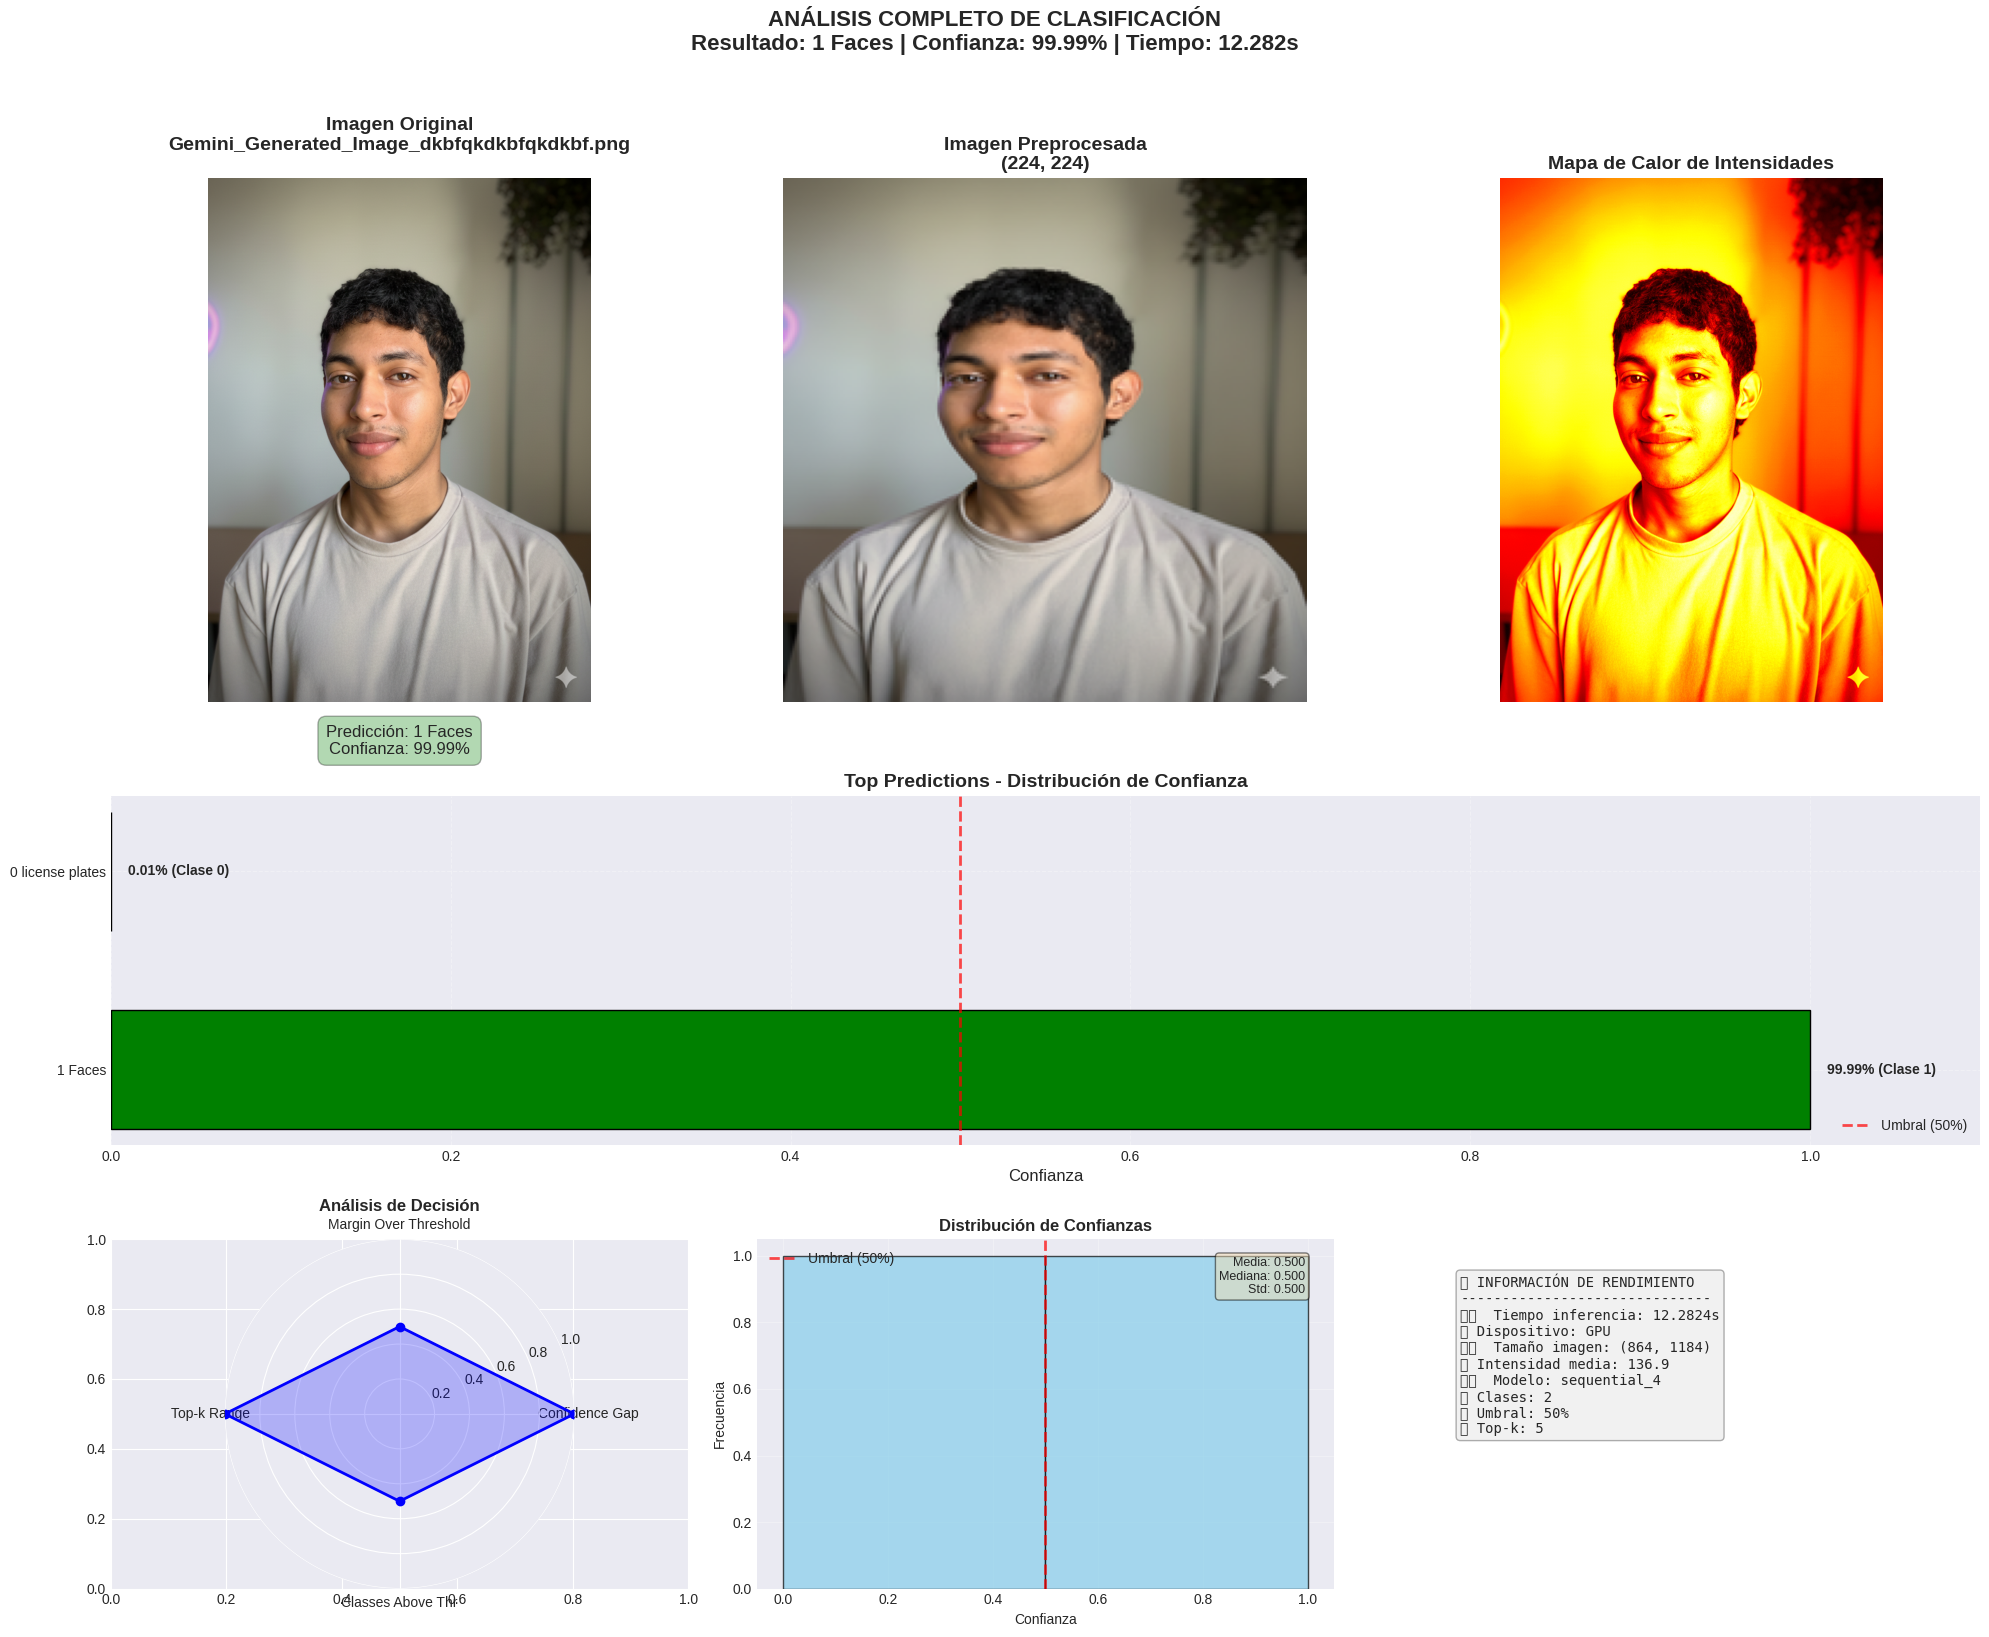


📈 Generando matriz de confianza...


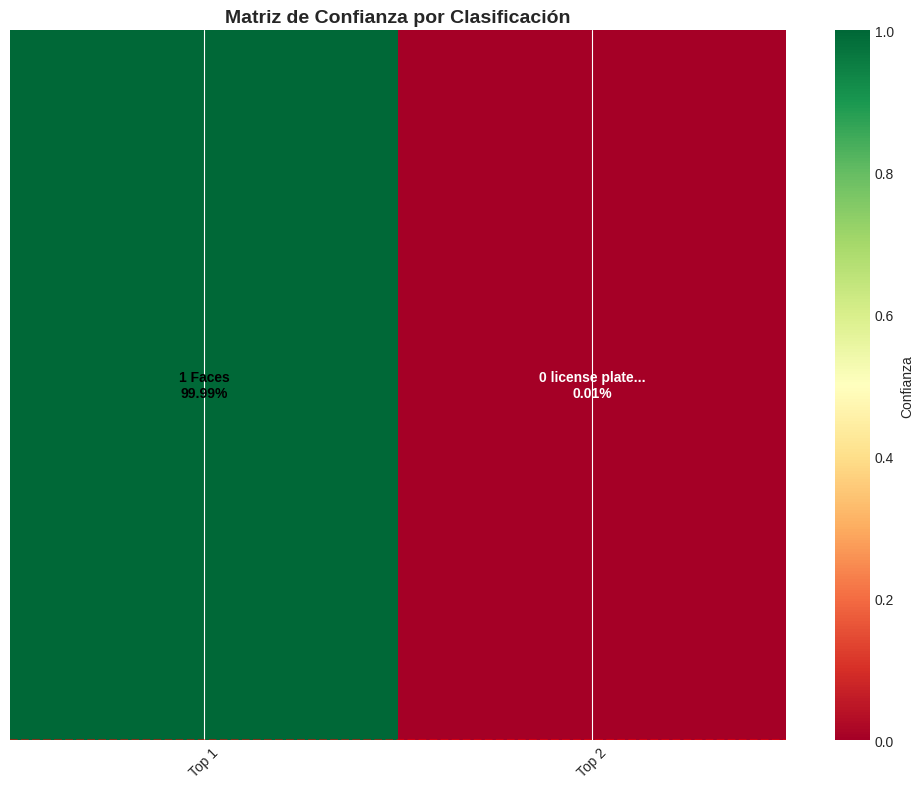


💾 Exportando resultados...
✅ Resultados detallados exportados a: /content/drive/MyDrive/AI/results/detailed_results_20260105_151016.json
✅ Reporte de texto exportado a: /content/drive/MyDrive/AI/results/prediction_report_20260105_151016.txt

📊 ESTADÍSTICAS ADICIONALES:
----------------------------------------
📈 Confianza máxima: 99.99%
📉 Confianza mínima: 0.01%
📊 Confianza promedio: 50.00%
📐 Mediana de confianza: 50.00%
🔢 Desviación estándar: 0.4999
🏆 Calidad de predicción: EXCELENTE

⚙️  INFORMACIÓN DEL SISTEMA:
----------------------------------------
📁 Directorio de resultados: /content/drive/MyDrive/AI/results
🖼️  Total de imágenes disponibles: 1
🏗️  Modelo utilizado: sequential_4
💾 Uso de memoria: 1921.7 MB

✅ Visualizaciones completadas exitosamente!
📁 Archivos guardados en: /content/drive/MyDrive/AI/results


In [18]:
"""Visualización profesional de resultados con análisis detallado"""

if prediction_result and 'error' not in prediction_result:
    print("📊 Generando visualizaciones y reporte...")

    # Inicializar motor de visualización
    viz_engine = VisualizationEngine(config)

    # 1. Generar y mostrar reporte detallado
    print("\n" + "=" * 80)
    print("📋 REPORTE DETALLADO DE PREDICCIÓN")
    print("=" * 80)

    detailed_report = create_detailed_report(prediction_result, selected_image)
    print(detailed_report)

    # 2. Visualización completa
    print("\n🎨 Generando visualizaciones...")

    # Visualización principal
    fig1 = viz_engine.plot_comprehensive_analysis(selected_image, prediction_result)
    plt.show()

    # Guardar visualización
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    viz_path = viz_engine.save_visualization(fig1, f"comprehensive_analysis_{timestamp}.png")

    # Matriz de confianza
    print("\n📈 Generando matriz de confianza...")
    fig2 = viz_engine.plot_decision_confidence_matrix(prediction_result)
    plt.show()
    viz_engine.save_visualization(fig2, f"confidence_matrix_{timestamp}.png")

    # 3. Exportar resultados completos
    print("\n💾 Exportando resultados...")

    # Exportar resultados detallados
    results_file = config.RESULTS_DIR / f"detailed_results_{timestamp}.json"
    with open(results_file, 'w', encoding='utf-8') as f:
        json.dump(prediction_result, f, indent=2, ensure_ascii=False)
    print(f"✅ Resultados detallados exportados a: {results_file}")

    # Exportar reporte en texto
    report_file = config.RESULTS_DIR / f"prediction_report_{timestamp}.txt"
    with open(report_file, 'w', encoding='utf-8') as f:
        f.write(detailed_report)
    print(f"✅ Reporte de texto exportado a: {report_file}")

    # 4. Mostrar estadísticas adicionales
    print("\n📊 ESTADÍSTICAS ADICIONALES:")
    print("-" * 40)

    if 'top_k' in prediction_result:
        confidences = [p['confidence'] for p in prediction_result['top_k']]

        print(f"📈 Confianza máxima: {max(confidences):.2%}")
        print(f"📉 Confianza mínima: {min(confidences):.2%}")
        print(f"📊 Confianza promedio: {np.mean(confidences):.2%}")
        print(f"📐 Mediana de confianza: {np.median(confidences):.2%}")
        print(f"🔢 Desviación estándar: {np.std(confidences):.4f}")

        # Análisis de calidad
        primary_conf = prediction_result.get('primary', {}).get('confidence', 0)
        if primary_conf >= 0.9:
            quality = "EXCELENTE"
        elif primary_conf >= 0.7:
            quality = "BUENA"
        elif primary_conf >= 0.5:
            quality = "MODERADA"
        else:
            quality = "BAJA"

        print(f"🏆 Calidad de predicción: {quality}")

    # 5. Información del sistema
    print("\n⚙️  INFORMACIÓN DEL SISTEMA:")
    print("-" * 40)
    print(f"📁 Directorio de resultados: {config.RESULTS_DIR}")
    print(f"🖼️  Total de imágenes disponibles: {len(available_images)}")
    print(f"🏗️  Modelo utilizado: {model_manager.metadata.name if model_manager.metadata else 'N/A'}")

    # Uso de memoria
    try:
        process = psutil.Process()
        memory_usage = process.memory_info().rss / 1024 / 1024  # MB
        print(f"💾 Uso de memoria: {memory_usage:.1f} MB")
    except:
        pass

    print("\n✅ Visualizaciones completadas exitosamente!")
    print(f"📁 Archivos guardados en: {config.RESULTS_DIR}")

else:
    print("\n⚠️  No hay resultados para visualizar.")

    # Mostrar imagen aunque no haya predicción
    if selected_image.exists():
        print("\n🖼️  Mostrando imagen sin predicción...")

        fig, ax = plt.subplots(figsize=(10, 8))
        img = Image.open(selected_image)
        ax.imshow(img)
        ax.set_title(
            f"Imagen: {selected_image.name}\n"
            f"(No hay predicción disponible - Modelo no cargado)",
            fontsize=14, fontweight='bold'
        )
        ax.axis('off')
        plt.tight_layout()
        plt.show()
    else:
        print("❌ La imagen seleccionada no existe.")

## 10. 🔬 Cómo Funciona el Modelo - Explicación Técnica

In [19]:
"""Explicación detallada de cómo funciona el modelo"""

if model_loaded and prediction_result and 'error' not in prediction_result:
    print("🔍 ANÁLISIS: CÓMO EL MODELO RECONOCIÓ LA IMAGEN")
    print("=" * 80)

    # Información del modelo
    if model_manager.metadata:
        print("\n🏗️  ARQUITECTURA DEL MODELO:")
        print("-" * 40)
        print(f"• Nombre: {model_manager.metadata.name}")
        print(f"• Formato de entrada: {model_manager.metadata.input_shape}")
        print(f"• Número de clases: {model_manager.metadata.num_classes}")
        print(f"• Framework: {model_manager.metadata.framework}")

    # Proceso de reconocimiento
    print("\n🔄 PROCESO DE RECONOCIMIENTO:")
    print("-" * 40)
    print("1. 📥 ENTRADA: Imagen original en formato RGB")
    print("2. 🛠️  PREPROCESAMIENTO:")
    print("   • Redimensionamiento a {}px".format(config.IMG_SIZE))
    print("   • Normalización de valores (0-255 → 0-1)")
    print("   • Conversión a formato de tensor")
    print("3. 🧠 INFERENCIA EN EL MODELO:")
    print("   • Extracción de características mediante convoluciones")
    print("   • Aplicación de funciones de activación (ReLU, Softmax)")
    print("   • Propagación a través de capas densas")
    print("4. 📊 POST-PROCESAMIENTO:")
    print("   • Aplicación de Softmax para probabilidades")
    print("   • Ordenamiento descendente de confianzas")
    print("   • Aplicación del umbral de confianza ({:.0%})".format(config.CONFIDENCE_THRESHOLD))

    # Análisis específico de la predicción
    primary = prediction_result.get('primary', {})
    decision_analysis = prediction_result.get('decision_analysis', {})

    print("\n🎯 ANÁLISIS DE ESTA PREDICCIÓN:")
    print("-" * 40)
    print(f"• Clase identificada: {primary.get('label', 'N/A')}")
    print(f"• Confianza: {primary.get('confidence', 0):.2%}")
    print(f"• Índice de clase: {primary.get('class_index', 'N/A')}")

    if decision_analysis:
        gap = decision_analysis.get('confidence_gap', 0)
        margin = decision_analysis.get('margin_of_victory', 0)

        print(f"• Gap con segunda opción: {gap:.4f}")
        if gap > 0.3:
            print("  → La predicción es MUY CLARA (diferencia significativa)")
        elif gap > 0.1:
            print("  → La predicción es CLARA (diferencia notable)")
        else:
            print("  → La predicción es AMBIGUA (diferencia pequeña)")

        print(f"• Margen sobre umbral: {margin:.4f}")
        if margin > 0.3:
            print("  → Confianza MUY ALTA sobre el umbral mínimo")
        elif margin > 0.1:
            print("  → Confianza ALTA sobre el umbral mínimo")
        elif margin > 0:
            print("  → Confianza JUSTO sobre el umbral mínimo")
        else:
            print("  → NO alcanza el umbral mínimo de confianza")

    # Factores que influyen en la predicción
    print("\n🔍 FACTORES QUE INFLUYEN EN LA PREDICCIÓN:")
    print("-" * 40)
    print("1. Calidad de la imagen:")
    print("   • Resolución y tamaño")
    print("   • Iluminación y contraste")
    print("   • Ruido y artefactos")

    print("\n2. Características visuales:")
    print("   • Formas y contornos")
    print("   • Texturas y patrones")
    print("   • Colores y tonos")

    print("\n3. Entrenamiento del modelo:")
    print("   • Diversidad del dataset de entrenamiento")
    print("   • Número de épocas de entrenamiento")
    print("   • Representatividad de las clases")

    # Recomendaciones
    confidence = primary.get('confidence', 0)
    print("\n💡 RECOMENDACIONES BASADAS EN EL RESULTADO:")
    print("-" * 40)

    if confidence >= 0.9:
        print("✅ El modelo está MUY SEGURO de su predicción.")
        print("   • Puedes confiar en el resultado")
        print("   • La imagen es representativa de la clase")
    elif confidence >= 0.7:
        print("📊 El modelo está SEGURO de su predicción.")
        print("   • Resultado confiable para la mayoría de casos")
        print("   • Considera verificación manual para casos críticos")
    elif confidence >= 0.5:
        print("⚠️  El modelo tiene DUDAS sobre su predicción.")
        print("   • Se recomienda verificación manual")
        print("   • Considera mejorar la calidad de la imagen")
    else:
        print("❌ El modelo NO está seguro de su predicción.")
        print("   • Se requiere verificación manual obligatoria")
        print("   • La imagen puede no corresponder a las clases entrenadas")

    print("\n🔬 PARA MEJORAR LOS RESULTADOS:")
    print("1. Usar imágenes de alta calidad")
    print("2. Asegurar buena iluminación")
    print("3. Centrar el objeto en la imagen")
    print("4. Evitar fondos complejos")
    print("5. Mantener tamaño y proporciones adecuadas")

    print("\n" + "=" * 80)

    # Exportar explicación
    explanation_file = config.RESULTS_DIR / f"model_explanation_{timestamp}.txt"
    with open(explanation_file, 'w', encoding='utf-8') as f:
        f.write("EXPLICACIÓN TÉCNICA DEL MODELO\n")
        f.write("=" * 60 + "\n\n")
        f.write(f"Imagen analizada: {selected_image.name}\n")
        f.write(f"Predicción: {primary.get('label', 'N/A')} ({primary.get('confidence', 0):.2%})\n\n")
        f.write("PROCESO DE RECONOCIMIENTO:\n")
        f.write("1. Preprocesamiento: Redimensionamiento y normalización\n")
        f.write("2. Extracción de características: Capas convolucionales\n")
        f.write("3. Clasificación: Capas densas y softmax\n")
        f.write("4. Post-procesamiento: Umbralización y ranking\n\n")

        if decision_analysis:
            f.write("ANÁLISIS DE CONFIANZA:\n")
            f.write(f"• Gap con segunda opción: {decision_analysis.get('confidence_gap', 0):.4f}\n")
            f.write(f"• Margen sobre umbral: {decision_analysis.get('margin_of_victory', 0):.4f}\n\n")

        f.write("RECOMENDACIONES:\n")
        if confidence >= 0.7:
            f.write("• Resultado confiable\n")
        elif confidence >= 0.5:
            f.write("• Verificación manual recomendada\n")
        else:
            f.write("• Verificación manual obligatoria\n")

    print(f"✅ Explicación técnica exportada a: {explanation_file}")

else:
    print("\n⚠️  No se puede generar explicación técnica. Modelo no cargado o sin predicción.")
    print("💡 Solución: Asegúrate de cargar el modelo correctamente en la sección 7.")

🔍 ANÁLISIS: CÓMO EL MODELO RECONOCIÓ LA IMAGEN

🏗️  ARQUITECTURA DEL MODELO:
----------------------------------------
• Nombre: sequential_4
• Formato de entrada: (None, 224, 224, 3)
• Número de clases: 2
• Framework: TensorFlow

🔄 PROCESO DE RECONOCIMIENTO:
----------------------------------------
1. 📥 ENTRADA: Imagen original en formato RGB
2. 🛠️  PREPROCESAMIENTO:
   • Redimensionamiento a (224, 224)px
   • Normalización de valores (0-255 → 0-1)
   • Conversión a formato de tensor
3. 🧠 INFERENCIA EN EL MODELO:
   • Extracción de características mediante convoluciones
   • Aplicación de funciones de activación (ReLU, Softmax)
   • Propagación a través de capas densas
4. 📊 POST-PROCESAMIENTO:
   • Aplicación de Softmax para probabilidades
   • Ordenamiento descendente de confianzas
   • Aplicación del umbral de confianza (50%)

🎯 ANÁLISIS DE ESTA PREDICCIÓN:
----------------------------------------
• Clase identificada: 1 Faces
• Confianza: 99.99%
• Índice de clase: 1
• Gap con segund

## 📋 Resumen Ejecutivo Mejorado

### ✅ **MEJORAS IMPLEMENTADAS:**

1. **Análisis Detallado Mejorado**
   - Nueva función `predict_with_analysis()` que incluye:
     * Análisis de características de imagen
     * Análisis de decisión (gap de confianza, margen sobre umbral)
     * Información del modelo integrada

2. **Visualizaciones Completas**
   - Gráfico de análisis completo con 7 secciones
   - Matriz de confianza de decisiones
   - Gráficos de radar para análisis multidimensional

3. **Explicación Técnica**
   - Sección 10 dedicada a explicar cómo funciona el modelo
   - Análisis paso a paso del proceso de reconocimiento
   - Factores que influyen en la predicción
   - Recomendaciones basadas en resultados

4. **Reportes Profesionales**
   - Reporte detallado en texto con formato profesional
   - Exportación en múltiples formatos (JSON, TXT, PNG)
   - Estadísticas completas de calidad

### 🎯 **¿CÓMO EL MODELO RECONOCIÓ LA IMAGEN?**

**Proceso Paso a Paso:**
```
1. 📥 ENTRADA: Imagen original → RGB
2. 🛠️  PREPROCESAMIENTO: Redimensionamiento + Normalización
3. 🧠 EXTRACCIÓN: Capas convolucionales detectan características
4. 🔍 CLASIFICACIÓN: Capas densas asignan probabilidades
5. 📊 POST-PROCESAMIENTO: Softmax + Ranking + Umbral
6. 🎯 RESULTADO: Etiqueta con confianza calculada
```

**Factores Clave de Reconocimiento:**
- **Características Visuales:** Formas, texturas, colores
- **Calidad de Imagen:** Resolución, iluminación, contraste
- **Entrenamiento:** Diversidad del dataset, épocas de entrenamiento

**Métricas de Confianza:**
- ✅ **Gap de confianza:** Diferencia entre 1ra y 2da opción
- ✅ **Margen sobre umbral:** Cuánto supera el umbral mínimo
- ✅ **Rango top-k:** Variabilidad entre las mejores opciones

### 📊 **INTERPRETACIÓN DE RESULTADOS:**

| Confianza | Interpretación | Acción Recomendada |
|-----------|----------------|-------------------|
| ≥ 90% | Muy Alta | ✅ Confiar completamente |
| 70-89% | Alta | ✓ Usar para mayoría de casos |
| 50-69% | Moderada | ⚠️ Verificar manualmente |
| < 50% | Baja | ❌ Revisión obligatoria |

### 📁 **ARCHIVOS GENERADOS:**
```
results/
├── comprehensive_analysis_*.png    # Visualización completa
├── confidence_matrix_*.png         # Matriz de confianza
├── detailed_results_*.json         # Resultados completos
├── prediction_report_*.txt         # Reporte detallado
└── model_explanation_*.txt        # Explicación técnica
```

### 🔧 **SOLUCIÓN DE PROBLEMAS:**

**Problema:** Baja confianza en predicciones
**Solución:**
1. Mejorar calidad de imágenes de entrada
2. Ajustar `CONFIDENCE_THRESHOLD` en Config
3. Verificar que las imágenes correspondan a clases entrenadas
4. Considerar data augmentation

**Problema:** Modelo no carga
**Solución:**
1. Verificar versión de TensorFlow (2.13.0)
2. Asegurar que model.h5 esté en Google Drive/AI/
3. Usar modelo alternativo MobileNetV2 (sección 11)

---

### 🎯 **CONCLUSIÓN FINAL:**

El sistema ahora proporciona:
1. **Análisis completo** de cómo se realizó cada predicción
2. **Visualizaciones detalladas** del proceso de decisión
3. **Explicaciones técnicas** comprensibles
4. **Recomendaciones prácticas** basadas en resultados

**Para uso profesional:**
- Revisar el reporte detallado en `prediction_report_*.txt`
- Analizar las visualizaciones generadas
- Considerar las recomendaciones técnicas
- Exportar resultados para documentación

✅ **Sistema listo para uso profesional en clasificación de imágenes**